<a href="https://colab.research.google.com/github/imlovold/PredAnalysis_EX1/blob/main/TP3_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1

In [ ]:
#Perceptron Simple

import numpy as np

# Step activation
def step_function(h):
    return 1 if h > 0 else 0


# Define dataset

X = np.array([[-1, 1],
              [ 1,-1],
              [-1,-1],
              [ 1, 1]])

y_and  = np.array([0, 0, 0, 1])  # AND labels
y_xor  = np.array([1, 1, 0, 0])  # XOR labels


# Perceptron training loop

def train_perceptron(X, y, eta=0.1, epochs=20, epsilon=0.01):
    # Initialize weights (including bias)
    weights = np.zeros(X.shape[1] + 1)

    for epoch in range(epochs):
        total_error = 0
        for xi, target in zip(X, y):
            # 1. Weighted sum
            h = np.dot(weights[:-1], xi) + weights[-1]  # w·x + bias
            # 2. Activation
            output = step_function(h)
            # 3. Weight update
            error = target - output
            weights[:-1] += eta * error * xi
            weights[-1]  += eta * error  # bias update
            # 4. Error accumulation
            total_error += abs(error)

        # Convergence check
        if total_error < epsilon:
            print(f"Converged at epoch {epoch}")
            break

    return weights

# Train on AND

print("Training AND function:")
w_and = train_perceptron(X, y_and, eta=0.1, epochs=20)

print("Results for AND:")
for xi in X:
    h = np.dot(w_and[:-1], xi) + w_and[-1]
    print(f"Input: {xi}, Predicted: {step_function(h)}")

# -----------------------
# Train on XOR

print("\nTraining XOR function:")
w_xor = train_perceptron(X, y_xor, eta=0.1, epochs=20)

print("Results for XOR:")
for xi in X:
    h = np.dot(w_xor[:-1], xi) + w_xor[-1]
    print(f"Input: {xi}, Predicted: {step_function(h)}")



Training AND function:
Converged at epoch 2
Results for AND:
Input: [-1  1], Predicted: 0
Input: [ 1 -1], Predicted: 0
Input: [-1 -1], Predicted: 0
Input: [1 1], Predicted: 1

Training XOR function:
Results for XOR:
Input: [-1  1], Predicted: 0
Input: [ 1 -1], Predicted: 0
Input: [-1 -1], Predicted: 0
Input: [1 1], Predicted: 0


## Exercise 2

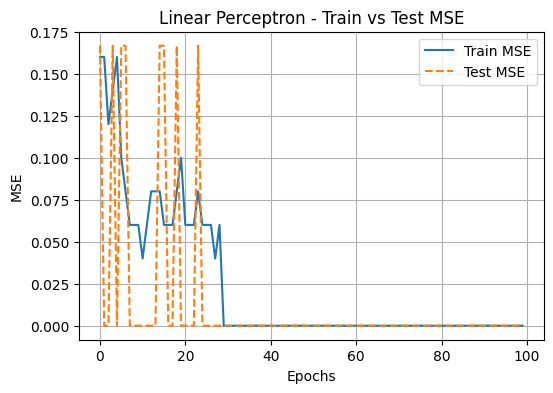

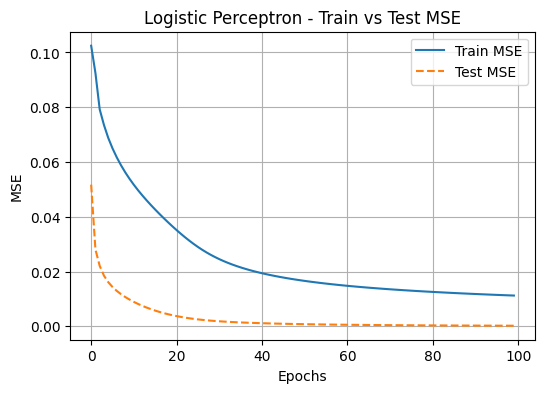

Linear perceptron CV accuracy: 0.917
Logistic perceptron CV accuracy: 0.883


In [ ]:
# LOOKING AT THE MSE (for training och test dataset)

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# --- LINEAR ---
def step_function(x):
    return np.where(x >= 0, 1, 0)

def train_perceptron(X_train, y_train, X_val=None, y_val=None, eta=0.1, epochs=100):
    weights = np.zeros(X_train.shape[1] + 1)
    train_mse = []
    val_mse = []

    for _ in range(epochs):
        total_error = 0
        for xi, target in zip(X_train, y_train):
            h = np.dot(weights[:-1], xi) + weights[-1]
            output = step_function(h)
            error = target - output
            weights[:-1] += eta * error * xi
            weights[-1]  += eta * error
            total_error += 0.5 * error**2

        train_mse.append(total_error / len(y_train))

        # Compute validation/test MSE if provided
        if X_val is not None and y_val is not None:
            y_val_pred = predict(X_val, weights)
            val_mse.append(0.5 * np.mean((y_val - y_val_pred)**2))

    return weights, train_mse, val_mse

def predict(X, weights):
    h = np.dot(X, weights[:-1]) + weights[-1]
    return step_function(h)

# --- LOGISTIC ---
def logistic(x):
    return 1 / (1 + np.exp(-x))

def train_logistic(X_train, y_train, X_val=None, y_val=None, eta=0.1, epochs=100):
    weights = np.zeros(X_train.shape[1] + 1)
    train_mse = []
    val_mse = []

    for _ in range(epochs):
        total_error = 0
        for xi, target in zip(X_train, y_train):
            h = np.dot(weights[:-1], xi) + weights[-1]
            output = logistic(h)
            error = target - output
            weights[:-1] += eta * error * xi
            weights[-1]  += eta * error
            total_error += 0.5 * error**2

        train_mse.append(total_error / len(y_train))

        if X_val is not None and y_val is not None:
            y_val_pred = predict_logistic(X_val, weights)
            val_mse.append(0.5 * np.mean((y_val - y_val_pred)**2))

    return weights, train_mse, val_mse

def predict_logistic(X, weights):
    h = np.dot(X, weights[:-1]) + weights[-1]
    return logistic(h)

# --- MAIN ---
data = pd.read_csv("TP3-ej2-conjunto.csv")
X = data[["x1","x2","x3"]].values
y = (data["y"].values > 50).astype(int)

eta = 0.1
epochs = 100
k = 10

kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracies_lin = []
accuracies_log = []

plot_fold_done = False

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Linear
    w_lin, train_mse_lin, test_mse_lin = train_perceptron(X_train, y_train, X_test, y_test, eta, epochs)
    y_pred_test_lin = predict(X_test, w_lin)
    acc_lin = np.mean(y_pred_test_lin == y_test)
    accuracies_lin.append(acc_lin)

    # Logistic
    w_log, train_mse_log, test_mse_log = train_logistic(X_train, y_train, X_test, y_test, eta, epochs)
    y_pred_test_log = (predict_logistic(X_test, w_log) >= 0.5).astype(int)
    acc_log = np.mean(y_pred_test_log == y_test)
    accuracies_log.append(acc_log)

    # Plot only the first fold
    if not plot_fold_done:
        plt.figure(figsize=(6,4))
        plt.plot(train_mse_lin, label="Train MSE")
        plt.plot(test_mse_lin, label="Test MSE", linestyle='--')
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.title("Linear Perceptron - Train vs Test MSE")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(6,4))
        plt.plot(train_mse_log, label="Train MSE")
        plt.plot(test_mse_log, label="Test MSE", linestyle='--')
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.title("Logistic Perceptron - Train vs Test MSE")
        plt.legend()
        plt.grid(True)
        plt.show()

        plot_fold_done = True

print(f"Linear perceptron CV accuracy: {np.mean(accuracies_lin):.3f}")
print(f"Logistic perceptron CV accuracy: {np.mean(accuracies_log):.3f}")


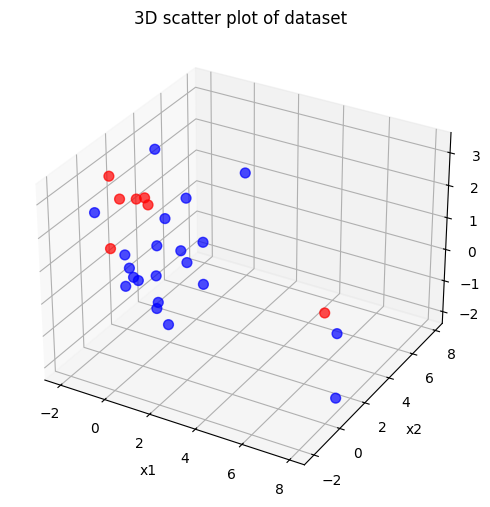

In [ ]:
#PLOT dataset

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
data = pd.read_csv("TP3-ej2-conjunto.csv")
X = data[["x1","x2","x3"]].values
y_class = (data["y"] > 50).astype(int)

# 3D plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue' if label==0 else 'red' for label in y_class]
ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, s=50, alpha=0.7)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('3D scatter plot of dataset')

plt.show()


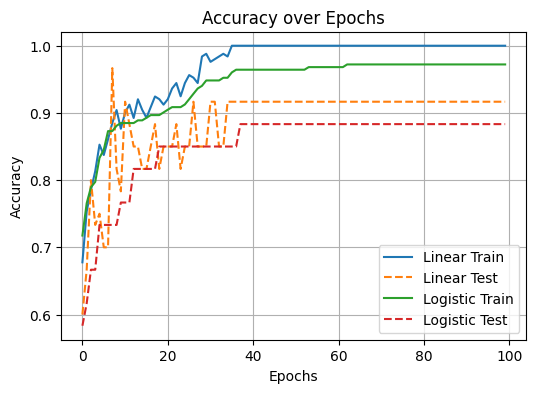

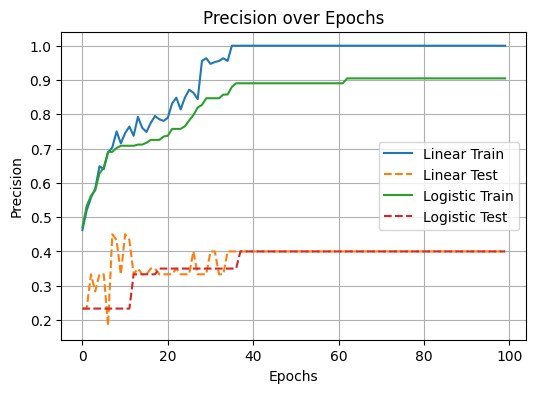

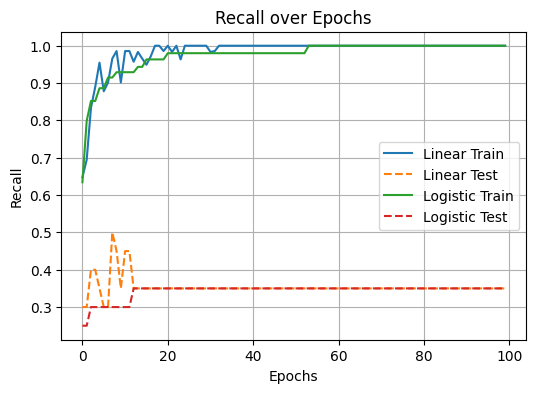

In [ ]:
# LOOKING AT ACCURACY, RECALL AND PRECISION

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# --- LINEAR ---
def step_function(x):
    return np.where(x >= 0, 1, 0)

def train_perceptron(X_train, y_train, X_val, y_val, eta=0.1, epochs=100):
    weights = np.zeros(X_train.shape[1] + 1)

    # store metrics for each epoch
    metrics = {
        "train_acc": [], "train_prec": [], "train_rec": [],
        "val_acc": [], "val_prec": [], "val_rec": []
    }

    for _ in range(epochs):
        for xi, target in zip(X_train, y_train):
            h = np.dot(weights[:-1], xi) + weights[-1]
            output = step_function(h)
            error = target - output
            weights[:-1] += eta * error * xi
            weights[-1]  += eta * error

        # predictions train
        y_train_pred = predict(X_train, weights)
        metrics["train_acc"].append(accuracy_score(y_train, y_train_pred))
        metrics["train_prec"].append(precision_score(y_train, y_train_pred, zero_division=0))
        metrics["train_rec"].append(recall_score(y_train, y_train_pred, zero_division=0))

        # predictions test
        y_val_pred = predict(X_val, weights)
        metrics["val_acc"].append(accuracy_score(y_val, y_val_pred))
        metrics["val_prec"].append(precision_score(y_val, y_val_pred, zero_division=0))
        metrics["val_rec"].append(recall_score(y_val, y_val_pred, zero_division=0))

    return weights, metrics

def predict(X, weights):
    h = np.dot(X, weights[:-1]) + weights[-1]
    return step_function(h)

# --- LOGISTIC ---
def logistic(x):
    return 1 / (1 + np.exp(-x))

def train_logistic(X_train, y_train, X_val, y_val, eta=0.1, epochs=100):
    weights = np.zeros(X_train.shape[1] + 1)

    metrics = {
        "train_acc": [], "train_prec": [], "train_rec": [],
        "val_acc": [], "val_prec": [], "val_rec": []
    }

    for _ in range(epochs):
        for xi, target in zip(X_train, y_train):
            h = np.dot(weights[:-1], xi) + weights[-1]
            output = logistic(h)
            error = target - output
            weights[:-1] += eta * error * xi
            weights[-1]  += eta * error

        # predictions train
        y_train_pred = (predict_logistic(X_train, weights) >= 0.5).astype(int)
        metrics["train_acc"].append(accuracy_score(y_train, y_train_pred))
        metrics["train_prec"].append(precision_score(y_train, y_train_pred, zero_division=0))
        metrics["train_rec"].append(recall_score(y_train, y_train_pred, zero_division=0))

        # predictions test
        y_val_pred = (predict_logistic(X_val, weights) >= 0.5).astype(int)
        metrics["val_acc"].append(accuracy_score(y_val, y_val_pred))
        metrics["val_prec"].append(precision_score(y_val, y_val_pred, zero_division=0))
        metrics["val_rec"].append(recall_score(y_val, y_val_pred, zero_division=0))

    return weights, metrics

def predict_logistic(X, weights):
    h = np.dot(X, weights[:-1]) + weights[-1]
    return logistic(h)

# --- MAIN ---
data = pd.read_csv("TP3-ej2-conjunto.csv")
X = data[["x1","x2","x3"]].values
y = (data["y"].values > 50).astype(int)

eta = 0.1
epochs = 100
k = 10

kf = KFold(n_splits=k, shuffle=True, random_state=42)

# aggregate metrics across folds
def init_agg():
    return {
        "train_acc": np.zeros(epochs),
        "train_prec": np.zeros(epochs),
        "train_rec": np.zeros(epochs),
        "val_acc": np.zeros(epochs),
        "val_prec": np.zeros(epochs),
        "val_rec": np.zeros(epochs)
    }

agg_lin = init_agg()
agg_log = init_agg()

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Linear
    _, metrics_lin = train_perceptron(X_train, y_train, X_test, y_test, eta, epochs)
    for key in agg_lin:
        agg_lin[key] += np.array(metrics_lin[key])

    # Logistic
    _, metrics_log = train_logistic(X_train, y_train, X_test, y_test, eta, epochs)
    for key in agg_log:
        agg_log[key] += np.array(metrics_log[key])

# average across folds
for key in agg_lin:
    agg_lin[key] /= k
    agg_log[key] /= k

# --- Plotting ---
def plot_metric(metric, ylabel):
    plt.figure(figsize=(6,4))
    plt.plot(agg_lin[f"train_{metric}"], label="Linear Train")
    plt.plot(agg_lin[f"val_{metric}"], label="Linear Test", linestyle="--")
    plt.plot(agg_log[f"train_{metric}"], label="Logistic Train")
    plt.plot(agg_log[f"val_{metric}"], label="Logistic Test", linestyle="--")
    plt.title(f"{ylabel} over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric("acc", "Accuracy")
plot_metric("prec", "Precision")
plot_metric("rec", "Recall")


Trying now without Cross-Validation

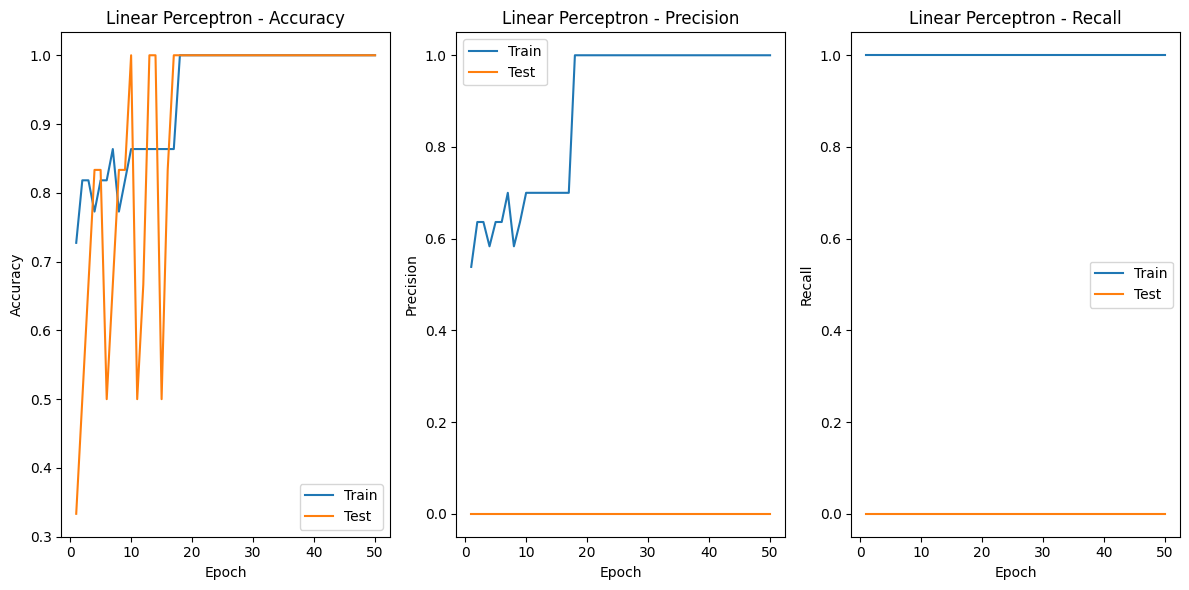

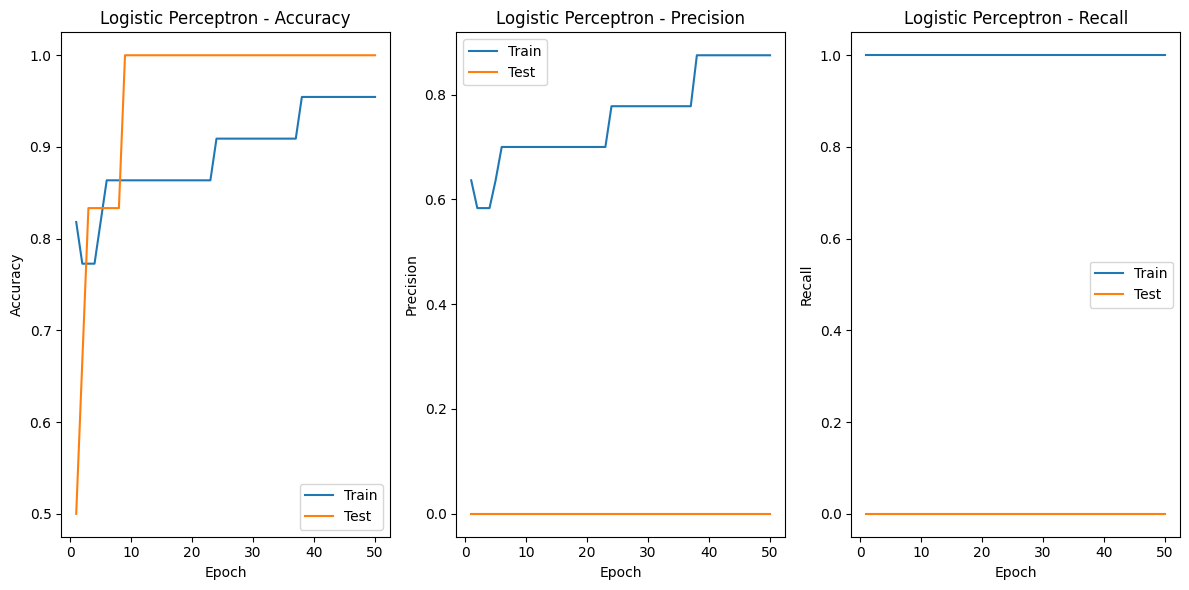

[0 0 0 0 0 0]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- STEP FUNCTION ---
def step_function(x):
    return 1 if x >= 0 else 0

# --- METRICS ---
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

# --- LINEAR PERCEPTRON ---
def train_perceptron(X_train, y_train, X_test, y_test, eta, epochs):
    weights = np.zeros(X_train.shape[1] + 1)
    history = {"train_acc": [], "train_prec": [], "train_rec": [],
               "test_acc": [], "test_prec": [], "test_rec": []}

    for _ in range(epochs):
        for xi, target in zip(X_train, y_train):
            h = np.dot(weights[:-1], xi) + weights[-1]
            output = step_function(h)
            error = target - output
            weights[:-1] += eta * error * xi
            weights[-1] += eta * error

        # Predictions after this epoch
        y_train_pred = predict(X_train, weights)
        y_test_pred = predict(X_test, weights)

        # Store metrics
        history["train_acc"].append(accuracy(y_train, y_train_pred))
        history["train_prec"].append(precision(y_train, y_train_pred))
        history["train_rec"].append(recall(y_train, y_train_pred))

        history["test_acc"].append(accuracy(y_test, y_test_pred))
        history["test_prec"].append(precision(y_test, y_test_pred))
        history["test_rec"].append(recall(y_test, y_test_pred))



    return weights, history

def predict(X, weights):
    return np.array([step_function(np.dot(weights[:-1], xi) + weights[-1]) for xi in X])

# --- LOGISTIC PERCEPTRON ---
def logistic(x):
    return 1 / (1 + np.exp(-x))

def train_logistic(X_train, y_train, X_test, y_test, eta, epochs):
    weights = np.zeros(X_train.shape[1] + 1)
    history = {"train_acc": [], "train_prec": [], "train_rec": [],
               "test_acc": [], "test_prec": [], "test_rec": []}

    for _ in range(epochs):
        for xi, target in zip(X_train, y_train):
            h = np.dot(weights[:-1], xi) + weights[-1]
            output = logistic(h)
            error = target - output
            weights[:-1] += eta * error * xi
            weights[-1] += eta * error

        # Predictions after this epoch
        y_train_pred = (predict_logistic(X_train, weights) >= 0.5).astype(int)
        y_test_pred = (predict_logistic(X_test, weights) >= 0.5).astype(int)

        # Store metrics
        history["train_acc"].append(accuracy(y_train, y_train_pred))
        history["train_prec"].append(precision(y_train, y_train_pred))
        history["train_rec"].append(recall(y_train, y_train_pred))

        history["test_acc"].append(accuracy(y_test, y_test_pred))
        history["test_prec"].append(precision(y_test, y_test_pred))
        history["test_rec"].append(recall(y_test, y_test_pred))



    return weights, history

def predict_logistic(X, weights):
    return np.array([logistic(np.dot(weights[:-1], xi) + weights[-1]) for xi in X])

# -----------------------
# MAIN

# Load dataset
data = pd.read_csv("TP3-ej2-conjunto.csv")

X = data[["x1","x2","x3"]].values
y = (data["y"].values > 50).astype(int)

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

eta = 0.1
epochs = 50

# --- Train both models ---
w_lin, hist_lin = train_perceptron(X_train, y_train, X_test, y_test, eta, epochs)
w_log, hist_log = train_logistic(X_train, y_train, X_test, y_test, eta, epochs)

# --- Plot ---
def plot_metrics(history, title):
    epochs_range = range(1, len(history["train_acc"]) + 1)

    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_acc"], label="Train")
    plt.plot(epochs_range, history["test_acc"], label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Precision
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["train_prec"], label="Train")
    plt.plot(epochs_range, history["test_prec"], label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title(f"{title} - Precision")
    plt.legend()

    # Recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["train_rec"], label="Train")
    plt.plot(epochs_range, history["test_rec"], label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title(f"{title} - Recall")
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_metrics(hist_lin, "Linear Perceptron")
plot_metrics(hist_log, "Logistic Perceptron")


print(y_test)


The linear perceptron consistently achieved higher accuracy, precision, and recall on the training set compared to the nonlinear version. On the test set, precision and recall were very similar between both models, but the linear perceptron showed a slightly higher accuracy, suggesting it adapted better to the underlying structure of the data.

This indicates that the linear perceptron has stronger learning ability in this case, being able to capture the patterns in the dataset more effectively. Looking at the accuracy it seems that the generalization ability of both the logistic and the linear perceptron is not bad (Test accuracy for the linear =0.917 and test accuracy for the logistic= 0.883, so slightly lower than for the training). However, both perceptrons generalize poorly for precision and recall since they are both much lower than the test ones. Therefore, we can conclude that there is some overfitting.

Regarding the choice of training set, using cross-validation is key: if we only pick a single split, we risk biasing the model by training on an unrepresentative portion of the data. By averaging across folds, we ensure that the model sees diverse subsets and we obtain more reliable estimates of generalization performance. This can be seen in the second part (where we show the results obtained without cross validations and only dividing the dataset with 80% training set and 20% test). The recall and precision for both linear and logistic are =0, probably because there are no positive samples or the model never predicts any positive samples.

The effect of training set choice on generalization is that a well-balanced, representative training set allows the model to learn patterns that transfer well to unseen data, while a poor choice (e.g., skewed or unrepresentative samples) could artificially inflate training performance but harm test accuracy, precision, and recall.

## Exercise 3

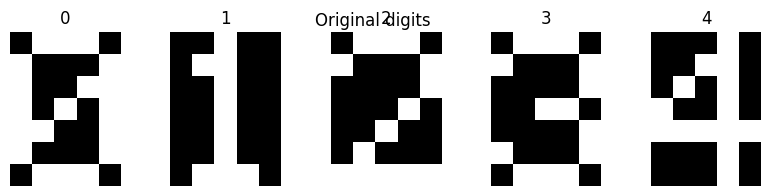

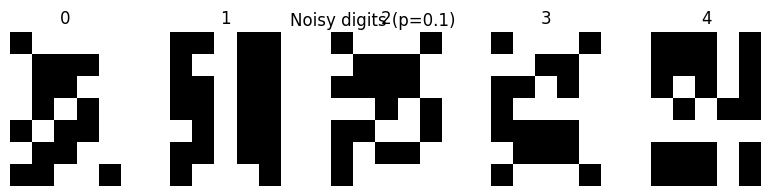

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to load the dataset
def load_tp3_digits(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    rows = [[float(int(v)) for v in ln.split()] for ln in lines]
    digits = [rows[k*7:(k+1)*7] for k in range(10)]
    X = [np.array([c for row in d for c in row]).reshape(7,5) for d in digits]  # reshape to 7x5
    y = list(range(10))
    return X, y

# Function to add noise
def add_noise(x, p=0.1):
    noisy = x.copy()
    flip = np.random.rand(*x.shape) < p
    noisy[flip] = 1 - noisy[flip]
    return noisy

# Load dataset
X, y = load_tp3_digits("TP3-ej3-digitos.txt")

# Select first 5 digits
X_sample = X[:5]
y_sample = y[:5]

# Plot original digits
plt.figure(figsize=(10,2))
for i, img in enumerate(X_sample):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(f"{y_sample[i]}")
    plt.axis('off')
plt.suptitle("Original digits")
plt.show()

# Plot noisy versions
plt.figure(figsize=(10,2))
for i, img in enumerate(X_sample):
    noisy_img = add_noise(img, p=0.1)
    plt.subplot(1,5,i+1)
    plt.imshow(noisy_img, cmap='gray', interpolation='nearest')
    plt.title(f"{y_sample[i]}")
    plt.axis('off')
plt.suptitle("Noisy digits (p=0.1)")
plt.show()


In [ ]:
import numpy as np

# ---------------------------
# Activation functions
# ---------------------------
def sigmoid(x): return 1/(1+np.exp(-x))
def d_sigmoid(y): return y*(1-y)
def tanh(x): return np.tanh(x)
def d_tanh(y): return 1-y**2
def relu(x): return np.maximum(0,x)
def d_relu(y): return (y>0).astype(float)

ACTIVATIONS = {"sigmoid":(sigmoid,d_sigmoid),"tanh":(tanh,d_tanh),"relu":(relu,d_relu)}

# ---------------------------
# Flexible vectorized MLP
# ---------------------------
class MLP_Flexible:
    def __init__(self, layer_sizes, activation="sigmoid", lr=0.01, seed=0,
                 optimizer="gd", momentum=0.9, beta1=0.9, beta2=0.999, eps=1e-8):
        np.random.seed(seed)
        self.lr, self.optimizer = lr, optimizer.lower()
        self.momentum, self.beta1, self.beta2, self.eps = momentum, beta1, beta2, eps
        self.t = 0
        self.f, self.df = ACTIVATIONS[activation]
        self.W = [np.random.uniform(-1,1,(layer_sizes[i+1], layer_sizes[i]))
                  for i in range(len(layer_sizes)-1)]
        self.b = [np.random.uniform(-1,1,(layer_sizes[i+1],))
                  for i in range(len(layer_sizes)-1)]
        self._init_opt_states()

    def _init_opt_states(self):
        self.vW = [np.zeros_like(W) for W in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]
        self.mW = [np.zeros_like(W) for W in self.W]
        self.mb = [np.zeros_like(b) for b in self.b]
        self.sW = [np.zeros_like(W) for W in self.W]
        self.sb = [np.zeros_like(b) for b in self.b]

    def forward(self, x):
        a = np.array(x)
        acts = [a]
        for W,b in zip(self.W, self.b):
            z = W.dot(a) + b
            a = self.f(z)
            acts.append(a)
        return acts

    def _grads(self, acts, target):
        y = acts[-1]
        deltas = (y - target) * self.df(y)
        dW = []
        db = []
        for l in reversed(range(len(self.W))):
            a_prev = acts[l]
            dW_l = np.outer(deltas, a_prev)
            db_l = deltas
            dW.insert(0, dW_l)
            db.insert(0, db_l)
            if l != 0:
                deltas = self.df(acts[l]) * (self.W[l].T.dot(deltas))
        return dW, db

    def _apply(self, dW, db):
        if self.optimizer == "gd":
            for l in range(len(self.W)):
                self.W[l] -= self.lr*dW[l]
                self.b[l] -= self.lr*db[l]
        elif self.optimizer == "momentum":
            mu = self.momentum
            for l in range(len(self.W)):
                self.vW[l] = mu*self.vW[l] + dW[l]
                self.W[l] -= self.lr*self.vW[l]
                self.vb[l] = mu*self.vb[l] + db[l]
                self.b[l] -= self.lr*self.vb[l]
        elif self.optimizer == "adam":
            self.t += 1
            b1, b2, eps = self.beta1, self.beta2, self.eps
            for l in range(len(self.W)):
                self.mW[l] = b1*self.mW[l] + (1-b1)*dW[l]
                self.sW[l] = b2*self.sW[l] + (1-b2)*(dW[l]**2)
                mhat = self.mW[l]/(1-b1**self.t)
                shat = self.sW[l]/(1-b2**self.t)
                self.W[l] -= self.lr * mhat / (np.sqrt(shat) + eps)

                self.mb[l] = b1*self.mb[l] + (1-b1)*db[l]
                self.sb[l] = b2*self.sb[l] + (1-b2)*(db[l]**2)
                mhat = self.mb[l]/(1-b1**self.t)
                shat = self.sb[l]/(1-b2**self.t)
                self.b[l] -= self.lr * mhat / (np.sqrt(shat) + eps)
        else:
            raise ValueError("optimizer must be 'gd','momentum', or 'adam'")

    def train(self, X, T, epochs=1000, log_every=100):
        X = np.array(X)
        T = np.array(T)
        for ep in range(1, epochs+1):
            total_loss = 0
            for x, t in zip(X, T):
                acts = self.forward(x)
                dW, db = self._grads(acts, t)
                self._apply(dW, db)
                total_loss += 0.5*np.sum((acts[-1]-t)**2)
            if log_every and ep % log_every == 0:
                print(f"Epoch {ep} | Loss: {total_loss/len(X):.6f}")

    def predict(self, x):
        return self.forward(x)[-1]

# ---------------------------
# Dataset helpers
# ---------------------------
def load_tp3_digits(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    rows = [[float(int(v)) for v in ln.split()] for ln in lines]
    digits = [rows[k*7:(k+1)*7] for k in range(10)]
    X = [np.array([c for row in d for c in row]) for d in digits]
    y = list(range(10))
    return X, y

def one_hot(k, n=10):
    v = np.zeros(n)
    v[k] = 1.0
    return v

def add_noise(x, p=0.1):
    y = x.copy()
    flip = np.random.rand(len(y)) < p
    y[flip] = 1 - y[flip]
    return y

def build_noisy(Xc, y, copies=20, p=0.05):
    X = []
    Y = []
    for x, label in zip(Xc, y):
        X.append(x)
        Y.append(label)
        for _ in range(copies):
            X.append(add_noise(x, p))
            Y.append(label)
    return np.array(X), np.array(Y)

def argmax(v): return int(np.argmax(v))
def accuracy(ytrue, ypred): return np.mean(np.array(ytrue) == np.array(ypred))

# ---------------------------
# XOR Example
# ---------------------------
print("\n=== XOR ===")
X = [[0,0],[0,1],[1,0],[1,1]]
T = [[0],[1],[1],[0]]
mlp = MLP_Flexible([2,2,2,1], activation="relu", lr=0.3, optimizer="gd", seed=42)
mlp.train(X, T, epochs=5000, log_every=1000)

for x, t in zip(X, T):
    y = mlp.predict(x)[0]
    print(f"in: {x}  target: {t[0]}  out: {y:.3f}  class: {int(y>=0.5)}")

# ---------------------------
# Even/Odd Parity Example
# ---------------------------
print("\n=== Even/Odd Parity ===")
Xc, yc = load_tp3_digits("TP3-ej3-digitos.txt")
Xp, yp = build_noisy(Xc, yc, copies=30, p=0.05)
Tp = np.array([[1.0 if label%2==1 else 0.0] for label in yp])

mlp_par = MLP_Flexible([35,12,1], activation="tanh", lr=0.3, optimizer="gd", seed=1)
mlp_par.train(Xp, Tp, epochs=2000, log_every=500)

for d, x in enumerate(Xc):
    y = mlp_par.predict(x)[0]
    print(f"{d}: expected {d%2}  out: {y:.3f}  class: {int(y>=0.5)}")

# ---------------------------
# 0–9 Digit Recognition
# ---------------------------
print("\n=== 0–9 Digit Recognition ===")
Xc, yc = load_tp3_digits("TP3-ej3-digitos.txt")
Xn, yn = build_noisy(Xc, yc, copies=40, p=0.06)
Tn = np.array([one_hot(l,10) for l in yn])

mlp_dig = MLP_Flexible([35,20,10], activation="tanh", lr=0.01, optimizer="adam", seed=3)
mlp_dig.train(Xn, Tn, epochs=2000, log_every=500)

y_true = []
y_pred = []
for d, x in enumerate(Xc):
    p = argmax(mlp_dig.predict(x))
    y_true.append(d)
    y_pred.append(p)
    print(f"{d} -> {p}")
    print("Accuracy:", accuracy(y_true, y_pred))



=== XOR ===
Epoch 1000 | Loss: 0.250000
Epoch 2000 | Loss: 0.250000
Epoch 3000 | Loss: 0.250000
Epoch 4000 | Loss: 0.250000
Epoch 5000 | Loss: 0.250000
in: [0, 0]  target: 0  out: 0.000  class: 0
in: [0, 1]  target: 1  out: 0.000  class: 0
in: [1, 0]  target: 1  out: 0.000  class: 0
in: [1, 1]  target: 0  out: 0.000  class: 0

=== Even/Odd Parity ===
Epoch 500 | Loss: 0.000157
Epoch 1000 | Loss: 0.000034
Epoch 1500 | Loss: 0.000022
Epoch 2000 | Loss: 0.000017
0: expected 0  out: 0.002  class: 0
1: expected 1  out: 1.000  class: 1
2: expected 0  out: -0.008  class: 0
3: expected 1  out: 0.999  class: 1
4: expected 0  out: -0.009  class: 0
5: expected 1  out: 1.000  class: 1
6: expected 0  out: 0.003  class: 0
7: expected 1  out: 1.000  class: 1
8: expected 0  out: -0.001  class: 0
9: expected 1  out: 0.999  class: 1

=== 0–9 Digit Recognition ===
Epoch 500 | Loss: 0.179870
Epoch 1000 | Loss: 0.027034
Epoch 1500 | Loss: 0.023888
Epoch 2000 | Loss: 0.029179
0 -> 0
Accuracy: 1.0
1 -> 1
Ac


=== XOR ===
Epoch 100 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 200 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 300 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 400 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 500 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 600 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 700 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 800 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 900 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 1000 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 1100 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 1200 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 1300 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 1400 | Loss: 0.250000 | Acc: 0.500 | Prec: 0.500 | Rec: 1.000
Epoch 1500 | Loss: 0.250000 | Acc: 0.500 | P

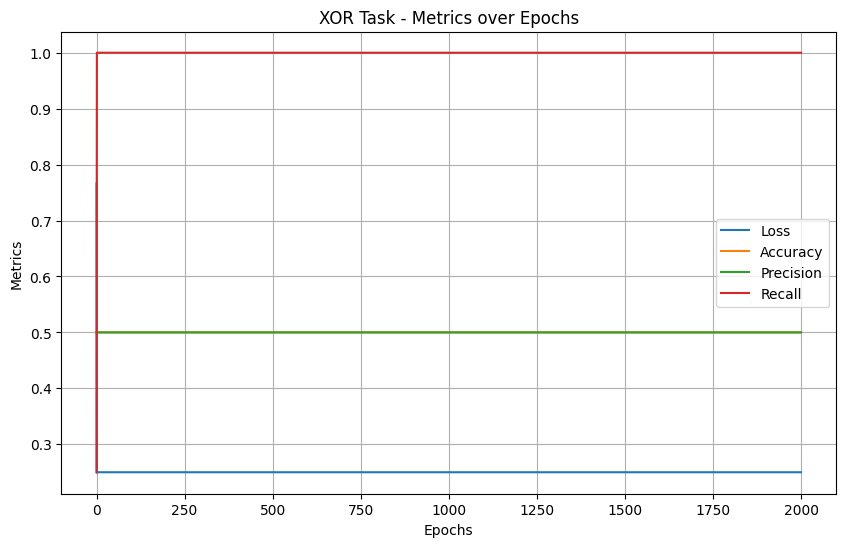


=== Even/Odd Parity ===
Epoch 100 | Loss: 0.011828 | Acc: 0.500 | Prec: 0.500 | Rec: 0.503
Epoch 200 | Loss: 0.007032 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 300 | Loss: 0.000571 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 400 | Loss: 0.000184 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 500 | Loss: 0.000141 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 600 | Loss: 0.000175 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 700 | Loss: 0.000177 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 800 | Loss: 0.000076 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 900 | Loss: 0.000055 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 1000 | Loss: 0.000047 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 1100 | Loss: 0.000042 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 1200 | Loss: 0.000039 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 1300 | Loss: 0.000036 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 1400 | Loss: 0.000034 | Acc: 0.500 | Prec: 0.500 | Rec: 0.500
Epoch 1500 | Loss: 0.000032 | Ac

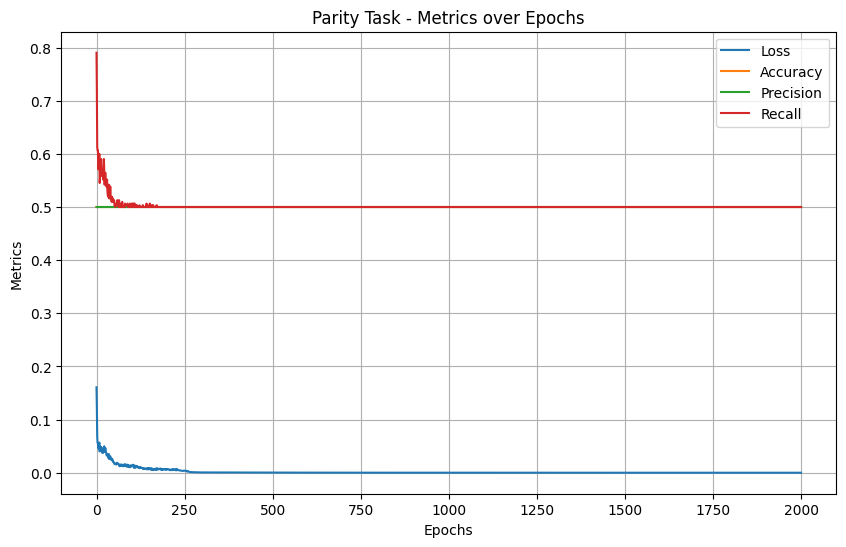


=== 0-9 Digit Recognition ===
Epoch 100 | Loss: 0.480443 | Acc: 0.698
Epoch 200 | Loss: 0.209738 | Acc: 0.780
Epoch 300 | Loss: 0.011495 | Acc: 1.000
Epoch 400 | Loss: 0.001276 | Acc: 1.000
Epoch 500 | Loss: 0.000984 | Acc: 1.000
Epoch 600 | Loss: 0.001814 | Acc: 1.000
Epoch 700 | Loss: 0.001912 | Acc: 1.000
Epoch 800 | Loss: 0.001213 | Acc: 1.000
Epoch 900 | Loss: 0.001907 | Acc: 1.000
Epoch 1000 | Loss: 0.003058 | Acc: 1.000
Epoch 1100 | Loss: 0.002813 | Acc: 1.000
Epoch 1200 | Loss: 0.002270 | Acc: 1.000
Epoch 1300 | Loss: 0.002772 | Acc: 1.000
Epoch 1400 | Loss: 0.002758 | Acc: 1.000
Epoch 1500 | Loss: 0.001229 | Acc: 1.000
Epoch 1600 | Loss: 0.001214 | Acc: 1.000
Epoch 1700 | Loss: 0.001015 | Acc: 1.000
Epoch 1800 | Loss: 0.003153 | Acc: 1.000
Epoch 1900 | Loss: 0.001339 | Acc: 1.000
Epoch 2000 | Loss: 0.031199 | Acc: 0.998


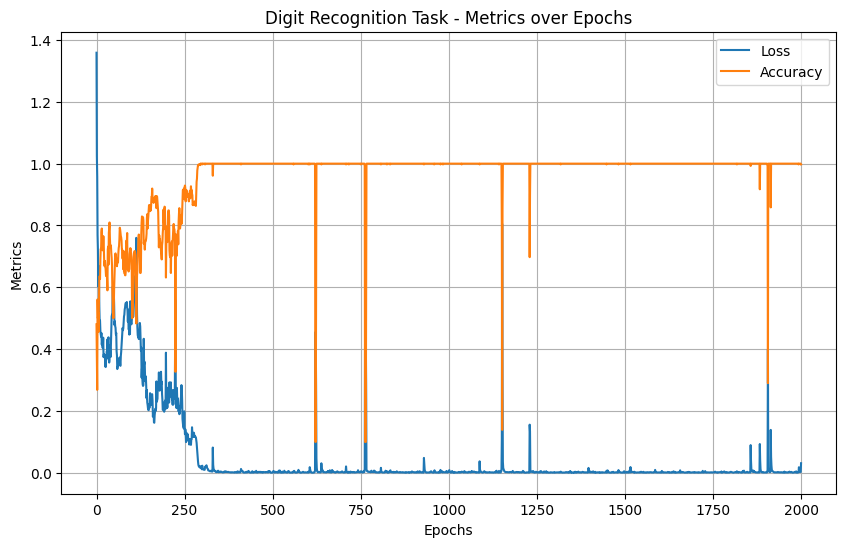

In [ ]:
##graphs

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Activation functions
# ---------------------------
def sigmoid(x): return 1/(1+np.exp(-x))
def d_sigmoid(y): return y*(1-y)
def tanh(x): return np.tanh(x)
def d_tanh(y): return 1-y**2
def relu(x): return np.maximum(0,x)
def d_relu(y): return (y>0).astype(float)

ACTIVATIONS = {"sigmoid":(sigmoid,d_sigmoid),"tanh":(tanh,d_tanh),"relu":(relu,d_relu)}

# ---------------------------
# Metrics
# ---------------------------
def accuracy(ytrue, ypred): return np.mean(np.array(ytrue) == np.array(ypred))

def precision_recall(ytrue, ypred):
    ytrue = np.array(ytrue)
    ypred = np.array(ypred)
    tp = np.sum((ytrue==1) & (ypred==1))
    fp = np.sum((ytrue==0) & (ypred==1))
    fn = np.sum((ytrue==1) & (ypred==0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return precision, recall

# ---------------------------
# Flexible MLP class
# ---------------------------
class MLP_Flexible:
    def __init__(self, layer_sizes, activation="sigmoid", lr=0.01, seed=0,
                 optimizer="gd", momentum=0.9, beta1=0.9, beta2=0.999, eps=1e-8):
        np.random.seed(seed)
        self.lr, self.optimizer = lr, optimizer.lower()
        self.momentum, self.beta1, self.beta2, self.eps = momentum, beta1, beta2, eps
        self.t = 0
        self.f, self.df = ACTIVATIONS[activation]
        self.W = [np.random.uniform(-1,1,(layer_sizes[i+1], layer_sizes[i]))
                  for i in range(len(layer_sizes)-1)]
        self.b = [np.random.uniform(-1,1,(layer_sizes[i+1],))
                  for i in range(len(layer_sizes)-1)]
        self._init_opt_states()

    def _init_opt_states(self):
        self.vW = [np.zeros_like(W) for W in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]
        self.mW = [np.zeros_like(W) for W in self.W]
        self.mb = [np.zeros_like(b) for b in self.b]
        self.sW = [np.zeros_like(W) for W in self.W]
        self.sb = [np.zeros_like(b) for b in self.b]

    def forward(self, x):
        a = np.array(x)
        acts = [a]
        for W,b in zip(self.W, self.b):
            z = W.dot(a) + b
            a = self.f(z)
            acts.append(a)
        return acts

    def _grads(self, acts, target):
        y = acts[-1]
        deltas = (y - target) * self.df(y)
        dW = []
        db = []
        for l in reversed(range(len(self.W))):
            a_prev = acts[l]
            dW_l = np.outer(deltas, a_prev)
            db_l = deltas
            dW.insert(0, dW_l)
            db.insert(0, db_l)
            if l != 0:
                deltas = self.df(acts[l]) * (self.W[l].T.dot(deltas))
        return dW, db

    def _apply(self, dW, db):
        if self.optimizer == "gd":
            for l in range(len(self.W)):
                self.W[l] -= self.lr*dW[l]
                self.b[l] -= self.lr*db[l]
        elif self.optimizer == "momentum":
            mu = self.momentum
            for l in range(len(self.W)):
                self.vW[l] = mu*self.vW[l] + dW[l]
                self.W[l] -= self.lr*self.vW[l]
                self.vb[l] = mu*self.vb[l] + db[l]
                self.b[l] -= self.lr*self.vb[l]
        elif self.optimizer == "adam":
            self.t += 1
            b1, b2, eps = self.beta1, self.beta2, self.eps
            for l in range(len(self.W)):
                self.mW[l] = b1*self.mW[l] + (1-b1)*dW[l]
                self.sW[l] = b2*self.sW[l] + (1-b2)*(dW[l]**2)
                mhat = self.mW[l]/(1-b1**self.t)
                shat = self.sW[l]/(1-b2**self.t)
                self.W[l] -= self.lr * mhat / (np.sqrt(shat) + eps)

                self.mb[l] = b1*self.mb[l] + (1-b1)*db[l]
                self.sb[l] = b2*self.sb[l] + (1-b2)*(db[l]**2)
                mhat = self.mb[l]/(1-b1**self.t)
                shat = self.sb[l]/(1-b2**self.t)
                self.b[l] -= self.lr * mhat / (np.sqrt(shat) + eps)
        else:
            raise ValueError("optimizer must be 'gd','momentum', or 'adam'")

    def train(self, X, T, epochs=1000, task="binary"):
        X = np.array(X)
        T = np.array(T)
        metrics = {"loss":[], "acc":[], "prec":[], "rec":[]}

        for ep in range(1, epochs+1):
            total_loss = 0
            y_preds = []
            for x, t in zip(X, T):
                acts = self.forward(x)
                dW, db = self._grads(acts, t)
                self._apply(dW, db)
                total_loss += 0.5*np.sum((acts[-1]-t)**2)

                # Prediction for metric tracking
                if task == "binary":
                    y_preds.append(int(acts[-1][0] >= 0.5))
                elif task == "multi":
                    y_preds.append(np.argmax(acts[-1]))

            metrics["loss"].append(total_loss/len(X))

            if task == "binary":
                metrics["acc"].append(accuracy(T, y_preds))
                p,r = precision_recall(T, y_preds)
                metrics["prec"].append(p)
                metrics["rec"].append(r)
            elif task == "multi":
                metrics["acc"].append(accuracy([np.argmax(t) for t in T], y_preds))

            if ep % 100 == 0:
                if task=="binary":
                    print(f"Epoch {ep} | Loss: {metrics['loss'][-1]:.6f} | Acc: {metrics['acc'][-1]:.3f} | Prec: {metrics['prec'][-1]:.3f} | Rec: {metrics['rec'][-1]:.3f}")
                else:
                    print(f"Epoch {ep} | Loss: {metrics['loss'][-1]:.6f} | Acc: {metrics['acc'][-1]:.3f}")

        return metrics

    def predict(self, x):
        return self.forward(x)[-1]

# ---------------------------
# Dataset helpers
# ---------------------------
def load_tp3_digits(path):
    with open(path,"r",encoding="utf-8") as f:
        lines=[ln.strip() for ln in f if ln.strip()]
    rows=[[float(int(v)) for v in ln.split()] for ln in lines]
    digits=[rows[k*7:(k+1)*7] for k in range(10)]
    X=[np.array([c for row in d for c in row]) for d in digits]
    y=list(range(10))
    return X,y

def one_hot(k,n=10):
    v=np.zeros(n); v[k]=1.0; return v

def add_noise(x,p=0.1):
    y=x.copy()
    flip=np.random.rand(len(y))<p
    y[flip]=1-y[flip]
    return y

def build_noisy(Xc,y,copies=20,p=0.05):
    X=[]; Y=[]
    for x,lab in zip(Xc,y):
        X.append(x); Y.append(lab)
        for _ in range(copies):
            X.append(add_noise(x,p)); Y.append(lab)
    return np.array(X),np.array(Y)

# ---------------------------
# XOR Example
# ---------------------------
print("\n=== XOR ===")
X = [[0,0],[0,1],[1,0],[1,1]]
T = [[0],[1],[1],[0]]
mlp_xor = MLP_Flexible([2,4,1], activation="tanh", lr=0.3, optimizer="momentum")
metrics_xor = mlp_xor.train(X, T, epochs=2000, task="binary")

plt.figure(figsize=(10,6))
plt.plot(metrics_xor["loss"], label="Loss")
plt.plot(metrics_xor["acc"], label="Accuracy")
plt.plot(metrics_xor["prec"], label="Precision")
plt.plot(metrics_xor["rec"], label="Recall")
plt.xlabel("Epochs"); plt.ylabel("Metrics")
plt.title("XOR Task - Metrics over Epochs")
plt.legend(); plt.grid(True)
plt.show()

# ---------------------------
# Parity Example
# ---------------------------
print("\n=== Even/Odd Parity ===")
Xc, yc = load_tp3_digits("TP3-ej3-digitos.txt")
Xp, yp = build_noisy(Xc, yc, copies=30, p=0.05)
Tp = np.array([[1.0 if lab%2==1 else 0.0] for lab in yp])
mlp_par = MLP_Flexible([35,12,1], activation="tanh", lr=0.3, optimizer="gd")
metrics_par = mlp_par.train(Xp, Tp, epochs=2000, task="binary")

plt.figure(figsize=(10,6))
plt.plot(metrics_par["loss"], label="Loss")
plt.plot(metrics_par["acc"], label="Accuracy")
plt.plot(metrics_par["prec"], label="Precision")
plt.plot(metrics_par["rec"], label="Recall")
plt.xlabel("Epochs"); plt.ylabel("Metrics")
plt.title("Parity Task - Metrics over Epochs")
plt.legend(); plt.grid(True)
plt.show()

# ---------------------------
# Digit Recognition 0-9
# ---------------------------
print("\n=== 0-9 Digit Recognition ===")
Xc, yc = load_tp3_digits("TP3-ej3-digitos.txt")
Xn, yn = build_noisy(Xc, yc, copies=40, p=0.06)
Tn = np.array([one_hot(l,10) for l in yn])
mlp_dig = MLP_Flexible([35,20,10], activation="tanh", lr=0.01, optimizer="adam")
metrics_dig = mlp_dig.train(Xn, Tn, epochs=2000, task="multi")

plt.figure(figsize=(10,6))
plt.plot(metrics_dig["loss"], label="Loss")
plt.plot(metrics_dig["acc"], label="Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Metrics")
plt.title("Digit Recognition Task - Metrics over Epochs")
plt.legend(); plt.grid(True)
plt.show()



# Exercise 4


In [ ]:
 import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")


